In [350]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
COLORS=sns.color_palette()

import torch
from torch import nn
import torch.nn.functional as f
from torchvision import datasets, transforms
from torch.utils.data import Dataset

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot, log_sum_exp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(3)

### $N$-dimensional features, scalar regression target, fully bayesian model

Here we use Pyro to build a fully Bayesian model

#### Toy Dataset 1

f shape: (80, 3)
a shape: (3, 1)


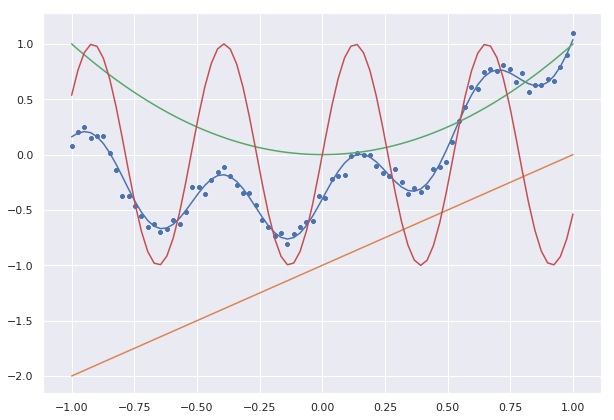

In [372]:
N = 80
true_a = np.array([0.6, 1, .3]).reshape(-1, 1)
true_b = np.asarray(0.2)
sigma = 0.06  # observation noise
x = np.linspace(-1, 1, N).reshape(-1, 1)
fx1 = x - 1
fx2 = x**2
fx3 = np.sin(12 * x)
fx = np.concatenate((fx1, fx2, fx3), axis=-1)
print('f shape:', fx.shape)
print('a shape:', true_a.shape)
t = fx @ true_a + true_b + sigma*np.random.randn(*x.shape)  # observations
plt.figure(figsize=(10, 7))
plt.plot(x, fx @ true_a + true_b)
plt.plot(x, fx)
sns.scatterplot(x[:, 0], t[:, 0])
plt.show() 

x = torch.tensor(x, dtype=torch.float)
t = torch.tensor(t, dtype=torch.float)

### Regression using an MLP

In [373]:
class MLP(nn.Module):
    def __init__(self, ninp, nhid, n_out):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(ninp, nhid), nn.ReLU(),
            nn.Linear(nhid, nhid), nn.ReLU(),
            nn.Linear(nhid, n_out)) 
    def forward(self, x):
        return self.features(x)

### Maximum Likelihood Estimation

In [394]:
logvar = nn.Parameter(torch.tensor(0.))  # for noise
regression_model = MLP(1, 32, 1)
regression_model

MLP(
  (features): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

[iteration 1000] loss: -127.3113
[iteration 2000] loss: -127.3343
[iteration 3000] loss: -127.3210
[iteration 4000] loss: -127.3698
[iteration 5000] loss: -127.3859
[iteration 6000] loss: -127.3975
[iteration 7000] loss: -127.3829
[iteration 8000] loss: -127.4076
[iteration 9000] loss: -127.4077
[iteration 10000] loss: -127.4354


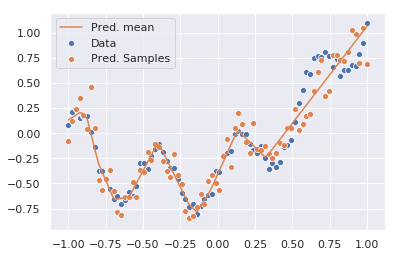

In [400]:
def loss_fn(x,t,logvar):
    expected_mse = (t - x)**2
    l = (0.5/logvar.exp() * expected_mse + 0.5*logvar)
    return l.sum()

optim = torch.optim.Adam(list(regression_model.parameters()) + [logvar], lr=0.001)
num_iterations = 10000

x_data, y_data = x,t

def visualise():
    y_pred = regression_model(x_data)
    samples = StochasticLayer()(y_pred, logvar).cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    x = x_data.cpu().detach().numpy()
    sns.scatterplot(x[:, 0], t[:, 0], label='Data', color=COLORS[0])
    sns.scatterplot(x[:, 0], samples[:, 0], label='Pred. Samples', color=COLORS[1])
    plt.plot(x[:, 0], y_pred[:, 0], label='Pred. mean', color=COLORS[1])
    plt.legend()
    plt.show() 
    
def main():
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model(x_data)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data, logvar)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 1000 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
            

main()
visualise()

### Bayesian Model

In [413]:
class StochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, logvar_q):
        kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
        return kl.sum()
    
class DiagonalNormalPosterior(StochasticLayer):
    def __init__(self, param):
        super().__init__()
        self.mu = nn.Parameter(param.data)
        self.logvar = nn.Parameter(-4 * torch.ones_like(param))
        
    def forward(self):
        return super().forward(self.mu, self.logvar)
    
    def get_kl(self):
        return super().get_kl(self.mu, self.logvar)

In [426]:
def _m2b(s):
    return s.replace(".","-")

def _b2m(s):
    return s.replace("-",".")

class BayesianModule(nn.Module):
    def __init__(self, model):
        super().__init__()

        posteriors = {}

        for name, param in model.named_parameters():

            posterior = DiagonalNormalPosterior(param)

            # append parameters
            posteriors[_m2b(name)] = posterior
        
        self.posteriors = nn.ModuleDict(posteriors)
    
        
    def sample_model(self, model):
        data = {_b2m(k) : p.forward() for k, p in self.posteriors.items()}
        model.load_state_dict(data)
        return model
    
    def forward(self, x, model, n_samples=1):
        samples = []
        for k in range(n_samples):
            model = self.sample_model(model)
            sample = model(x)
            samples += [sample.unsqueeze(0)]
        return torch.cat(samples,0)
    
    def get_kl(self):
        kls = sum(p.get_kl() for k,p in self.posteriors.items())
        return kls
        

In [427]:
import copy
logvar = nn.Parameter(torch.tensor(0., device=device))  # for noise
bayesian_regression_model = BayesianModule(regression_model)
ref_model = copy.deepcopy(regression_model).to(device)
bayesian_regression_model.to(device)

BayesianModule(
  (posteriors): ModuleDict(
    (features-0-bias): DiagonalNormalPosterior()
    (features-0-weight): DiagonalNormalPosterior()
    (features-2-bias): DiagonalNormalPosterior()
    (features-2-weight): DiagonalNormalPosterior()
    (features-4-bias): DiagonalNormalPosterior()
    (features-4-weight): DiagonalNormalPosterior()
  )
)

In [428]:
from IPython.display import clear_output
optim = torch.optim.Adam(list(bayesian_regression_model.parameters()) + [logvar], lr=0.0001)
num_iterations = 10000
n_samples = 1000

x_data, y_data = x.to(device),t.to(device)

def visualise():
    x = x_data.cpu().detach().numpy()
    y_pred = bayesian_regression_model(x_data, ref_model, n_samples=128)
    samples = StochasticLayer()(y_pred, logvar).cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    x = x_data.cpu().detach().numpy()
    #samples
    
    ci = np.percentile(y_pred, [25,75], axis = 0)
    y_mean = np.mean(y_pred, 0)
    plt.fill_between(x[:, 0], ci[0,:,0], ci[1,:,0], alpha=0.1, label="50% CI")
    sns.scatterplot(x[:, 0], t[:, 0], label='Data', color=COLORS[0])
    #sns.scatterplot(x[:, 0], samples[:, 0], label='Pred. Samples', color=COLORS[1])
    plt.plot(x[:, 0], y_mean[:, 0], label='Mean Prediction', color=COLORS[1])
    plt.legend()
    plt.show() 
    
def main():
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = bayesian_regression_model(x_data, ref_model, n_samples=n_samples)
        y_pred = y_pred.mean(0)
        # compute kl
        kl = bayesian_regression_model.get_kl()
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data, logvar)
        loss += kl
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        
        if (j + 1) % 100 == 0:
            clear_output()
            print(f"[iteration {j + 1}] loss: {loss.item():.3f}  KL {kl:.3f}" )
            visualise()

[iteration 6800] loss: 1365.130  KL 1371.200


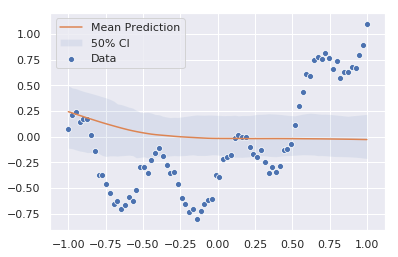

In [ ]:
main()

In [ ]:
print("here")